In [5]:
from ucimlrepo import fetch_ucirepo

# Load and aggregate to daily sales
online_retail = fetch_ucirepo(id=352)
df = pd.concat([online_retail.data.features, online_retail.data.targets], axis=1)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Aggregating to daily frequency to create a consistent time series
daily_df = df.groupby(df['InvoiceDate'].dt.date).agg({
    'Quantity': 'sum', 
    'UnitPrice': 'mean'
}).reset_index()

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from mapie.metrics.regression import (
    regression_coverage_score, 
    regression_mean_width_score
)
from sklearn.model_selection import train_test_split


def train_garch_conformal_hybrid(returns_train, returns_calib, alpha=0.1):
    """Fit GARCH model and compute (1-alpha) quantile of standardized residuals.
    
    1. Fit GARCH on training returns.
    2. Standardize residuals on calibration set.
    3. Conformalize the standardized residuals.
    """
    # Step 1: Fit GARCH(1,1)
    # Volatility is modeled as: σ_t^2 = ω + αε_{t-1}^2 + βσ_{t-1}^2
    am = arch_model(returns_train, vol="GARCH", p=1, q=1, rescale=False)
    res = am.fit(disp="off")
    
    # Step 2: Standardize calibration residuals
    # z_i = (y_i - μ_i) / σ_i
    mu_calib = res.forecast(horizon=1, align="origin").mean.iloc[-len(returns_calib):].values
    vol_calib = res.forecast(horizon=1, align="origin").variance.iloc[-len(returns_calib):].values
    vol_calib = np.sqrt(vol_calib).flatten()
    
    std_residuals = np.abs((returns_calib - mu_calib.flatten()) / vol_calib)
    
    # Step 3: Find the (1-alpha) quantile of standardized scores
    qz = np.quantile(std_residuals, 1 - alpha)
    
    return res, qz

def predict_hybrid(model, qz, returns_test):
    """Generate multi-step GARCH forecasts and scale by conformal score."""
    # Set horizon to the test set length for out-of-sample prediction
    horizon = len(returns_test)
    forecasts = model.forecast(horizon=horizon, reindex=False)
    
    # Extract and flatten the horizontal forecast row into 1D arrays
    mu_new = forecasts.mean.values.flatten()
    sigma_new = np.sqrt(forecasts.variance.values).flatten()
    
    y_low = mu_new - qz * sigma_new
    y_high = mu_new + qz * sigma_new
    
    return mu_new, y_low, y_high

returns = daily_df['Quantity'].pct_change().dropna()
ret_train, ret_rem = train_test_split(returns, test_size=0.4, shuffle=False)
ret_calib, ret_test = train_test_split(ret_rem, test_size=0.5, shuffle=False)

garch_res, q_factor = train_garch_conformal_hybrid(ret_train, ret_calib)
y_pred, y_low, y_high = predict_hybrid(garch_res, q_factor, ret_test)

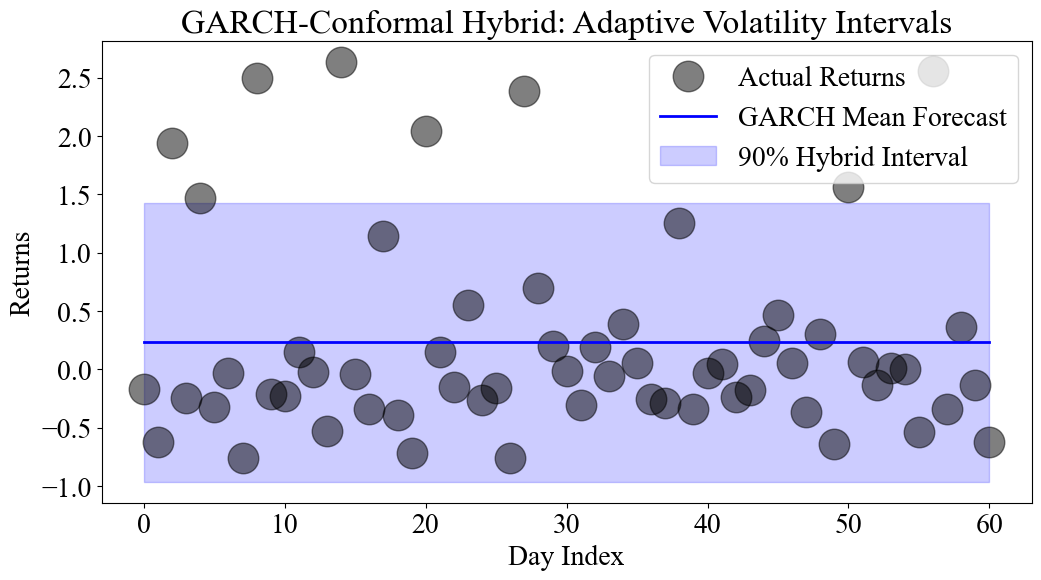

In [12]:
def plot_hybrid_forecast(y_true, y_pred, y_low, y_high):
    """Plot returns and adaptive hybrid intervals to visualize volatility clustering."""
    indices = np.arange(len(y_true))
    plt.figure(figsize=(12, 6))
    
    # Plot ground truth and point forecasts
    plt.plot(indices, y_true, "ko", label="Actual Returns", alpha=0.5)
    plt.plot(indices, y_pred, "b-", label="GARCH Mean Forecast")
    
    # Plot adaptive intervals
    plt.fill_between(
        indices, 
        y_low.ravel(), 
        y_high.ravel(), 
        color="blue", 
        alpha=0.2, 
        label="90% Hybrid Interval"
    )
    
    plt.title("GARCH-Conformal Hybrid: Adaptive Volatility Intervals")
    plt.xlabel("Day Index")
    plt.ylabel("Returns")
    plt.legend()
    plt.show()
    
plot_hybrid_forecast(ret_test, y_pred, y_low, y_high)